# Deep Learning Practice with CIFAR-10

Ref:    
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html    
https://teddylee777.github.io/pytorch/torchvision-transform/

<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2023-2/blob/main/ML_day7/7_4_Deep_Learning_Practice_with_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchsummary import summary

## Input Normalization

**Important: The output of torchvision datasets are PILImage images of range [0, 1]**

딥러닝 모델을 학습시키는 데에 있어 전처리는 필수적입니다. 특히 이미지의 경우 RGB 형식으로 표현될 경우 채널 당 픽셀값이 0~255까지 굉장히 큰 범위를 가지고 있기 때문에 어떠한 방식으로 이미지 데이터에 대해 **정규화(Normalization)** 처리를 하는 가에 따라 성능이 바뀌기도 합니다. 정규화를 진행하지 않을 경우, backpropagation을 통한 학습 자체가 유의미하게 이루어지지 않을 수 있습니다. 이미지 뿐만 아니라 모든 종류의 데이터에 대해 전처리를 어떻게 하는 것인가는 전반적인 모델의 학습결과에 큰 영향을 주게 됩니다.

In [2]:
# Define helper function to check statistics for each RGB channel
def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _ in dataset])
    print(f'shape: {imgs.shape}')
    
    min_r = np.min(imgs, axis=(2, 3))[:, 0].min()
    min_g = np.min(imgs, axis=(2, 3))[:, 1].min()
    min_b = np.min(imgs, axis=(2, 3))[:, 2].min()

    max_r = np.max(imgs, axis=(2, 3))[:, 0].max()
    max_g = np.max(imgs, axis=(2, 3))[:, 1].max()
    max_b = np.max(imgs, axis=(2, 3))[:, 2].max()

    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
    mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()
    std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
    std_b = np.std(imgs, axis=(2, 3))[:, 2].std()
    
    print(f'min: {min_r, min_g, min_b}')
    print(f'max: {max_r, max_g, max_b}')
    print(f'mean: {mean_r, mean_g, mean_b}')
    print(f'std: {std_r, std_g, std_b}')

### torchvision의 transforms를 활용한 전처리
`transforms.ToTensor()`: Tensor 형태로 변환    
`transforms.Normalize()`: mean, standard deviation을 이용하여 tensor image를 normalize함. 
* Input: tuple of means, tuple of std.dev. 
* Output value: (Pixel value - channel mean) / (channel std.dev)

Case 0: `transforms.ToTensor()`만 적용한 경우: 전처리 결과가 0~1 범위로 변환

In [3]:
transform_0 = transforms.Compose([
    transforms.ToTensor()
])

Case 1: `transforms.Normalize()`를 이용하여 전처리 결과가 -1~1 범위로 변환    
- min value: (0 - 0.5) / 0.5
- max value: (1 - 0.5) / 0.5

In [4]:
transform_1 = transforms.Compose([
    # ToTensor는 항상 포함해야 함. PIL Image 형태로는 Normalize 불가능.
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Case 2: Popular parameter를 이용해서 Normalize

In [5]:
transform_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

Case 3: Custom parameter를 이용해서 Normalize   
(ex) Sample mean, Sample std.dev

In [6]:
### Try something else

### Load Dataset

In [7]:
# transform = transform_0
transform = transform_1
# transform = transform_2

In [8]:
trainset = datasets.CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform = transform
)

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [01:37<00:00, 1742896.47it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


In [9]:
testset = datasets.CIFAR10(
    root = './data',
    train = False,
    download = True,
    transform = transform
)

Files already downloaded and verified


In [10]:
batch_size = 4

In [11]:
train_loader = DataLoader(
    trainset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 1
)

In [12]:
test_loader = DataLoader(
    testset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 1
)

In [13]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Check stats and print image

In [14]:
print_stats(trainset)

shape: (50000, 3, 32, 32)
min: (-1.0, -1.0, -1.0)
max: (1.0, 1.0, 1.0)
mean: (-0.017200625, -0.035683163, -0.10693816)
std: (0.121056795, 0.122249946, 0.13529024)


In [15]:
print_stats(testset)

shape: (10000, 3, 32, 32)
min: (-1.0, -1.0, -1.0)
max: (1.0, 1.0, 1.0)
mean: (-0.011571422, -0.029737204, -0.0991818)
std: (0.12095944, 0.12247972, 0.13516872)


**Recall: Always check the dimension and shape of the input**

`print_stats()`에서 확인한 바와 같이 현재 이미지의 형태는 (3,32,32) 형태이다. 시각화를 위해서는 (32, 32, 3) 형태로 변환해주어야 함.

In [16]:
# This is for transform_1
# How about for others????
def imshow(img):
    
    # unnormalize the image
    img = img / 2 + 0.5 
    
    # convert image to numpy array
    np_img = img.numpy()
    
    plt.imshow(np.transpose(np_img, (1,2,0)))
    
    plt.show()

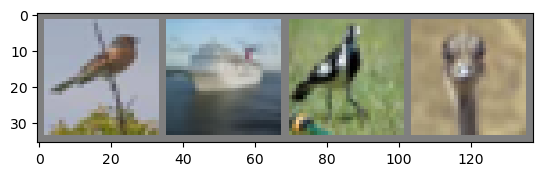

bird  ship  bird  bird 


In [17]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Build Neural Network: Fully Connected Only

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 2**8)
        self.fc2 = nn.Linear(2**8, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
net = Net()

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
net = net.to(device)

In [22]:
summary(net, (3,32,32), batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [4, 256]         786,688
            Linear-2                    [4, 84]          21,588
            Linear-3                    [4, 10]             850
Total params: 809,126
Trainable params: 809,126
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.01
Params size (MB): 3.09
Estimated Total Size (MB): 3.14
----------------------------------------------------------------


## Set Loss Function and Optimizer

`momentum`: momentum from previous parameters -> dampens oscillations    
`weight_decay`: L2 penalty in loss function

In [23]:
criterion = nn.CrossEntropyLoss()

In [24]:
optimizer = optim.SGD(
    net.parameters(), 
    lr=0.001, 
#     momentum=0.9,
#     weight_decay=0.9
)

Try some other optimizers!
* Adagrad
* RMSprop
* AdaDelta
* Adam

## Train the Network

In [25]:
num_epochs = 5

In [26]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.241
[1,  4000] loss: 2.100
[1,  6000] loss: 1.984
[1,  8000] loss: 1.886
[1, 10000] loss: 1.835
[1, 12000] loss: 1.784
[2,  2000] loss: 1.725
[2,  4000] loss: 1.703
[2,  6000] loss: 1.694
[2,  8000] loss: 1.657
[2, 10000] loss: 1.649
[2, 12000] loss: 1.627
[3,  2000] loss: 1.563
[3,  4000] loss: 1.598
[3,  6000] loss: 1.580
[3,  8000] loss: 1.557
[3, 10000] loss: 1.550
[3, 12000] loss: 1.514
[4,  2000] loss: 1.513
[4,  4000] loss: 1.505
[4,  6000] loss: 1.479
[4,  8000] loss: 1.471
[4, 10000] loss: 1.463
[4, 12000] loss: 1.474
[5,  2000] loss: 1.420
[5,  4000] loss: 1.425
[5,  6000] loss: 1.412
[5,  8000] loss: 1.418
[5, 10000] loss: 1.412
[5, 12000] loss: 1.413
Finished Training


In [27]:
# save trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test the Network

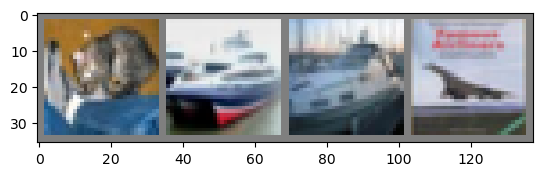

GroundTruth:  cat   ship  ship  plane


In [28]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [29]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [30]:
outputs = net(images)

In [31]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  cat   truck ship  ship 


### For the whole test dataset

In [32]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 49 %


In [33]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 52.2 %
Accuracy for class: car   is 52.1 %
Accuracy for class: bird  is 36.9 %
Accuracy for class: cat   is 27.9 %
Accuracy for class: deer  is 25.6 %
Accuracy for class: dog   is 39.6 %
Accuracy for class: frog  is 70.1 %
Accuracy for class: horse is 62.5 %
Accuracy for class: ship  is 68.4 %
Accuracy for class: truck is 59.5 %
